In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

"""
The PatchEmbedding class represents the patch embedding layer of the transformer model. 
It takes as input an image tensor and applies a convolutional operation to extract patches
from the image. These patches are then flattened and transposed to obtain the embeddings. 
The resulting tensor has the shape (batch_size, num_patches, d_model), where batch_size is 
the number of images in the batch, num_patches is the total number of patches in the image, 
and d_model is the dimension of the embedding.

"""
class PatchEmbedding(nn.Module):
    def __init__(self, d_model, patch_size):
        super(PatchEmbedding, self).__init__()
        self.patch_size = patch_size
        self.conv = nn.Conv2d(3, d_model, kernel_size=patch_size, stride=patch_size-1)

    def forward(self, x):
        x = self.conv(x)
        x = x.flatten(2).transpose(1, 2)
        return x

"""
The MLP class represents the multi-layer perceptron (MLP) component of the transformer model. 
It takes as input an embedding tensor and applies two fully connected layers. The purpose of the MLP is to introduce non-linearity and enable the model to 
learn complex patterns in the data. Dropout is applied to the intermediate representation for regularization.
"""
class MLP(nn.Module):
    def __init__(self, d_model, hidden_dim, dropout):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(d_model, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x

"""
The Attention class represents the attention mechanism used in the transformer model. 
It takes as input query, key, and value tensors and performs scaled dot-product attention. 
The attention scores are calculated by taking the dot product between the query and key, 
divided by the square root of the head dimension. Softmax activation is applied to obtain the 
attention weights, and dropout is applied to the attention weights for regularization. 
The values are then weighted by the attention weights and projected using the output linear layer.
"""
class Attention(nn.Module):
    def __init__(self, d_model, n_heads, dropout):
        super(Attention, self).__init__()
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads

        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)
        self.out_linear = nn.Linear(d_model, d_model)

    def forward(self, query, key, value, mask=None):
        batch_size, seq_len, _ = query.size()

        query = self.q_linear(query)
        key = self.k_linear(key)
        value = self.v_linear(value)

        query = query.view(batch_size, seq_len, self.n_heads, self.head_dim).transpose(1, 2)
        key = key.view(batch_size, seq_len, self.n_heads, self.head_dim).transpose(1, 2)
        value = value.view(batch_size, seq_len, self.n_heads, self.head_dim).transpose(1, 2)

        scores = torch.matmul(query, key.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float32))
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))

        attention = F.softmax(scores, dim=-1)
        attention = self.dropout(attention)

        x = torch.matmul(attention, value)
        x = x.transpose(1, 2).contiguous().view(batch_size, seq_len, -1)
        x = self.out_linear(x)

        return x

"""
The EncoderLayer class represents a single layer in the encoder of the transformer model. 
It consists of two sub-layers: self-attention and a feed-forward neural network (MLP). 
Layer normalization is applied before and after each sub-layer. The input tensor is passed 
through the self-attention mechanism, and its output is added to the input tensor with a 
residual connection. Layer normalization is applied to the sum, and the result is passed 
through the feed-forward neural network. Again, the output of the MLP is added to the 
input tensor with a residual connection and layer normalization is applied.
"""
class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, hidden_dim, dropout):
        super(EncoderLayer, self).__init__()
        self.attention = Attention(d_model, n_heads, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.mlp = MLP(d_model, hidden_dim, dropout)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        attention_output = self.attention(x, x, x, mask)
        x = self.norm1(x + self.dropout(attention_output))

        mlp_output = self.mlp(x)
        x = self.norm2(x + self.dropout(mlp_output))

        return x
"""
The Transformer class represents the complete transformer model. 
It consists of a patch embedding layer to convert the input images 
into patches, a stack of encoder layers,layer normalization, and a
fully connected layer for classification.In the forward method, 
the input images are first passed through the patch embedding layer 
to obtain the patch representations. Then, the patch representations 
are passed through each encoder layer in the stack. After the encoder 
layers, layer normalization is applied to the output.Global average 
pooling is then performed to reduce the sequence length to 1, and finally, 
the output is passed through the fully connected layer for classification.
"""
class Transformer(nn.Module):
    def __init__(self, d_model, n_heads, n_layers, num_classes, hidden_dim=1024, dropout=0.1):
        super(Transformer, self).__init__()
        self.patch_embedding = PatchEmbedding(d_model, patch_size=4)

        self.encoder_layers = nn.ModuleList([
            EncoderLayer(d_model, n_heads, hidden_dim, dropout)
            for _ in range(n_layers)
        ])

        self.norm = nn.LayerNorm(d_model)
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x, mask=None):
        x = self.patch_embedding(x)
        batch_size, seq_len, _ = x.size()

        for layer in self.encoder_layers:
            x = layer(x, mask)

        x = self.norm(x)
        x = x.mean(dim=1)  # Global average pooling
        x = self.fc(x)

        return x


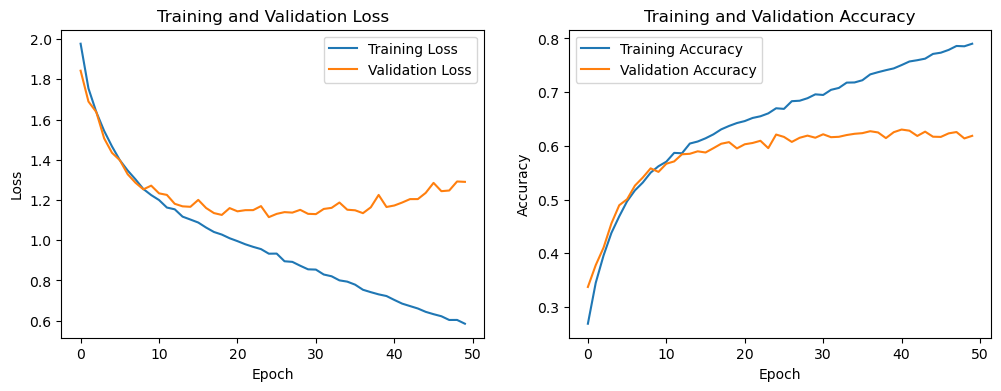

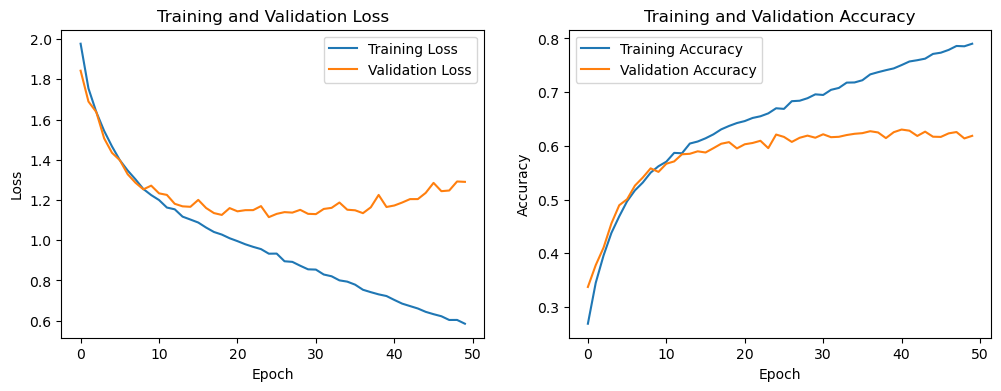

In [2]:
import torch
import torch.nn as nn
import random
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import IPython.display as display
import torch.optim.lr_scheduler as lr_scheduler


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Preprocess the images
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Calculate the sizes of training, validation, and test sets
total_size = len(dataset)
train_size = int(0.6 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size
random.seed(42)
# Split the dataset into training, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Define data loaders
batch_size = 500
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define model parameters
d_model = 256
n_heads = 8
n_layers = 6
num_classes = 10
dropout = 0.4

# Create the transformer model
model = Transformer(d_model, n_heads, n_layers, num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# Define learning rate scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1)

# Initialize lists to track accuracy and loss
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Create a figure for live plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Define the update function for live plotting
def update_plots(epoch):
    axs[0].cla()
    axs[1].cla()

    # Plot training and validation loss
    axs[0].plot(range(epoch), train_losses[:epoch], label='Training Loss')
    axs[0].plot(range(epoch), val_losses[:epoch], label='Validation Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Training and Validation Loss')
    axs[0].legend()

    # Plot training and validation accuracy
    axs[1].plot(range(epoch), train_accuracies[:epoch], label='Training Accuracy')
    axs[1].plot(range(epoch), val_accuracies[:epoch], label='Validation Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_title('Training and Validation Accuracy')
    axs[1].legend()

    # Update the plots
    display.clear_output(wait=True)
    display.display(plt.gcf())


# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        # Calculate loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Track accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        total_loss += loss.item()

    # Calculate training accuracy and loss
    train_accuracy = correct / total
    train_loss = total_loss / len(train_loader)

    # Evaluation on validation set
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)

            # Calculate loss
            loss = criterion(outputs, labels)

            # Track accuracy
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            val_loss += loss.item()

    # Calculate validation accuracy and loss
    val_accuracy = val_correct / val_total
    val_loss /= len(val_loader)
    
    # Append accuracy and loss to the lists
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Update the plots
    update_plots(epoch + 1)

#     # Print epoch statistics
#     print(f"Epoch {epoch + 1}/{num_epochs}:")
#     print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.4f}")
#     print(f"Validation Loss: {val_loss:.4f} | Validation_Acc: {val_accuracy:.4f}")
#     print("-------------------------------------")

# Save the trained model
torch.save(model.state_dict(), "transformer_cifar10.pth")


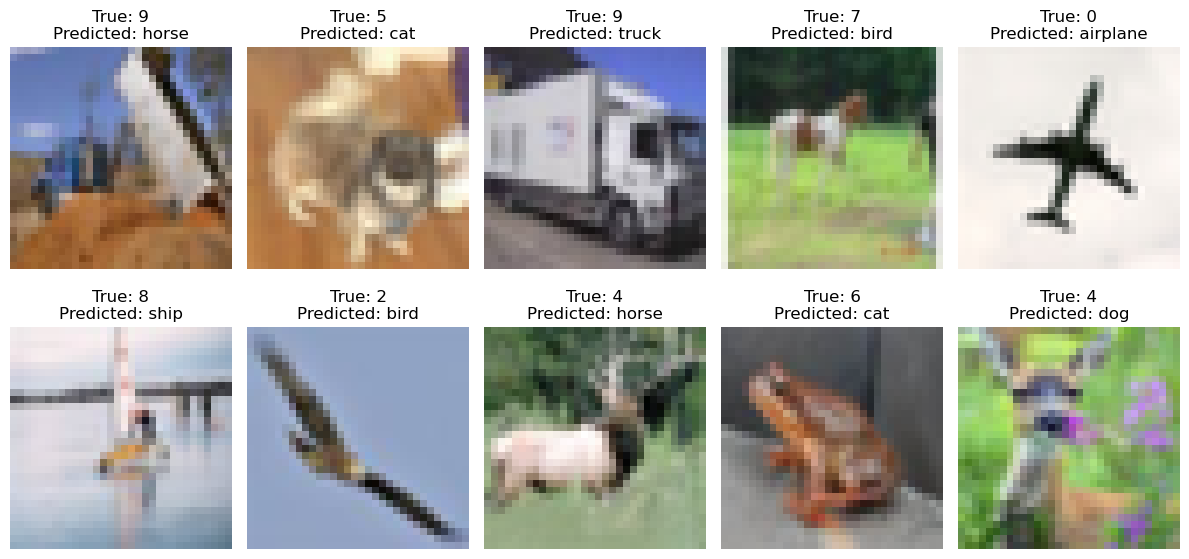

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Define the transformation for the input images
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=10, shuffle=True)



# Define the class labels for CIFAR-10
class_labels = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

# Define the model architecture

model = Transformer(d_model, n_heads, n_layers, num_classes)

# Load the trained model weights
model.load_state_dict(torch.load("/kaggle/working/transformer_cifar10.pth"))
model.eval()

# Function to plot images in a grid with predicted labels
def plot_images(images, labels, predicted_labels):
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    axes = axes.flatten()
    for i in range(len(images)):
        image = images[i].numpy().transpose((1, 2, 0))
        image = (image * 0.5) + 0.5  # Unnormalize the image
        label = labels[i]
        predicted_label = predicted_labels[i]
        axes[i].imshow(image)
        axes[i].set_title(f"True: {label}\nPredicted: {predicted_label}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()


# Pass the images through the model and predict their labels
images, labels = next(iter(testloader))
outputs = model(images)
_, predicted_labels = torch.max(outputs, 1)
predicted_labels = [class_labels[label] for label in predicted_labels]

# Plot the images with predicted labels
plot_images(images, labels, predicted_labels)